# Projet de Web Scraping : Analyse des laptops sur Jumia

Ce programme utilise la technologie de scraping **Selenium** pour extraire automatiquement des données à partir du site **Jumia Côte d'Ivoire**, dans la catégorie des ordinateurs portables (laptops).

L'objectif est de :
- Collecter des données telles que le **nom du produit**, le **prix**, la **marque**, la **note des utilisateurs**, le **nombre d’avis**, et le **lien du produit**.
- Structurer ces données dans un **DataFrame** à l’aide de **Pandas**.
- Effectuer une **analyse descriptive** pour dégager des insights utiles (ex. marques les plus présentes, gamme de prix, rapport qualité/prix).
- Réaliser un **data storytelling** qui pourrait appuyer la prise de décision d’une entreprise ou d’un consommateur.

Ce projet illustre des cas d’usage réel pour le **marketing digital**, la **veille concurrentielle**, ou la **recommandation produit**.


# Etape 0 - Importation des bibliothèques 
Nous allons importer toute les bibliothèque python que nous utiliserons pour le projet

In [1]:
# Importation des bibliothèques

import time # Time pour faire des pauses et éviter d'être bloqué par le site 
import pandas as pd 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

## Etape 1 : Lancement de Selenium 

In [2]:
# Configuration des options Chrome
options = Options()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")

# Utilisation de webdriver-manager pour gérer automatiquement le bon driver
service = Service(ChromeDriverManager().install())

# Lancement du navigateur
driver = webdriver.Chrome(service=service, options=options)

# Aller sur Jumia
driver.get("https://www.jumia.ci/ordinateurs-portables/")


Rappel sur l'bjectif global : Analyser la demande et les préférences des consommateurs Ivoirien en matière de laptop sur Jumia CI
Pour ce faire nous allons analyser 4 points clés à savoir :
* Les marques populaires 
* Les spécification de pc les plus recherchées (GPU, RAM, Stockage)
* La fourchette de prix populaires
* Note et avis clients

### Etape 2 : Les marques les plus populaire sur le site Jumia

In [3]:

# Fonction pour normaliser les marques on observe plusieur variance pour Lenovo
def normaliser_marque(marque):
    marque = marque.upper()
    if "LENOVO" in marque:
        return "LENOVO"
    elif "HP" in marque:
        return "HP"
    elif "DELL" in marque:
        return "DELL"
    elif "ASUS" in marque:
        return "ASUS"
    elif "MSI" in marque:
        return "MSI"
    elif "HUAWEI" in marque:
        return "HUAWEI"
    elif "APPLE" in marque:
        return "APPLE"
    elif "MICROSOFT" in marque:
        return "MICROSOFT"
    elif "ITEL" in marque:
        return "ITEL"
    elif "WSD" in marque:
        return "WSD"
    elif "GENERIC" in marque:
        return "GENERIC"
    else:
        return marque.strip()

# Scraping avec normalisation immédiate
all_brands = []

for page in range(1, 17): 
    print(f"📄 Page {page}")
    url = f"https://www.jumia.ci/pc-portables/?page={page}"
    driver.get(url)
    time.sleep(3)  # les règles de scraping du site (https://www.jumia.ci/robots.txt)

    products = driver.find_elements(By.CSS_SELECTOR, 'article.prd')

    for el in products:
        try:
            # Priorité : attribut 'data-gtm-brand'
            a_tag = el.find_element(By.CSS_SELECTOR, 'a.core')
            brand = a_tag.get_attribute("data-gtm-brand")
        except:
            brand = None

        if not brand:
            # Fallback : première partie du nom du produit
            try:
                name = el.find_element(By.CLASS_NAME, 'name').text
                brand = name.split()[0]
            except:
                brand = "INCONNUE"

        brand = normaliser_marque(brand)
        all_brands.append(brand)

#  Analyse des résultats
df_brands = pd.DataFrame(all_brands, columns=["Marque"])
brand_counts = df_brands["Marque"].value_counts().reset_index()
brand_counts.columns = ["Marque", "Occurrences"]

print(brand_counts)


📄 Page 1
📄 Page 2
📄 Page 3
📄 Page 4
📄 Page 5
📄 Page 6
📄 Page 7
📄 Page 8
📄 Page 9
📄 Page 10
📄 Page 11
📄 Page 12
📄 Page 13
📄 Page 14
📄 Page 15
📄 Page 16
        Marque  Occurrences
0           HP          381
1       LENOVO          155
2         DELL           41
3         ASUS           36
4         ITEL            6
5          WSD            2
6      GENERIC            2
7          LCD            2
8       HUAWEI            2
9          MSI            2
10  GAMERSHOOD            1
11   MICROSOFT            1
12          GM            1
13     GATEWAY            1
14       INTEL            1
15        ACER            1


In [4]:
# Sauvegarde en CSV pour un analyse ultérieur avec Power BI

brand_counts.to_csv(r"C:\Users\pc\Desktop\Data Jumia\brands_jumia.csv", index=False, encoding="utf-8")
print("Fichier 'brands_jumia.csv' exporté avec succès sur le Desktop.")


✅ Fichier 'brands_jumia.csv' exporté avec succès sur le Desktop.


 ### Etape 3 : Visualisation des données sur les marques les plus populaires en Côte d'Ivoire sur Jumia CI

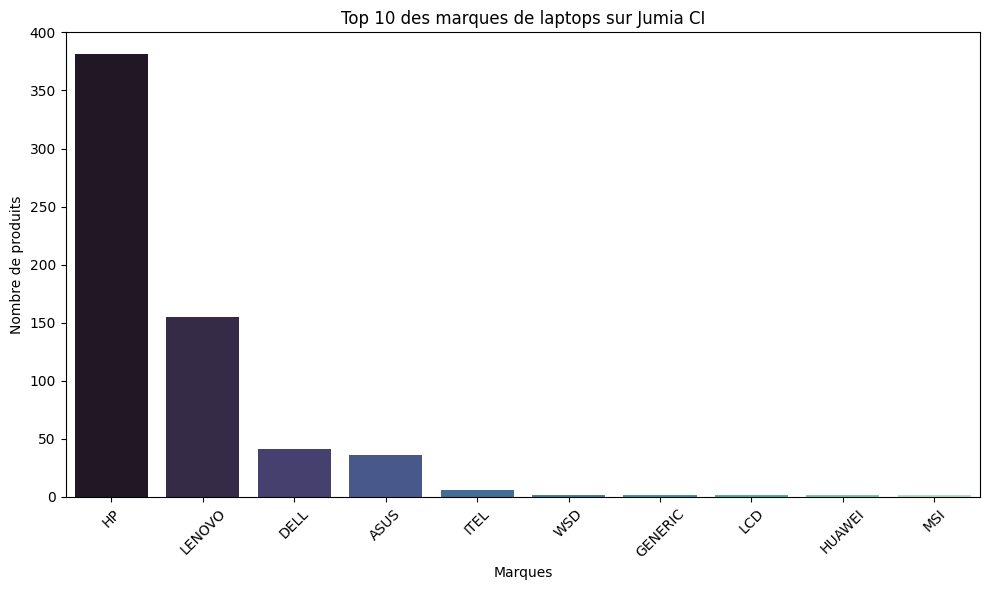

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.barplot(data=brand_counts.head(10), x="Marque", y="Occurrences", hue="Marque", palette="mako", legend=False)
plt.title("Top 10 des marques de laptops sur Jumia CI")
plt.ylabel("Nombre de produits")
plt.xlabel("Marques")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Etape 5 : Extraction des données sur les spécifications des laptops sur Jumia CI
Après extraction ces données sont sauvegardés dans un fichier csv sur les desktop pour nettoyage et analyse

In [6]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

# URL de base 
base_url = "https://www.jumia.ci/pc-portables/?page="

all_titles = []

# Il y a 16 pages sur le site de jumia à scraper
for page_num in range(1, 17):
    print(f"Scraping page {page_num}...")
    url = base_url + str(page_num)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur de chargement page {page_num}, code {response.status_code}")
        break
    
    soup = BeautifulSoup(response.text, 'html.parser')
    # récupérer toutes les balises <h3 class="name">
    titles = soup.find_all('h3', class_='name')
    
    for t in titles:
        all_titles.append(t.get_text(strip=True))
    
    time.sleep(1)  # pause entre requêtes pour éviter surcharge ou même blocage de Jumia
    
print(f"Total laptops récupérés : {len(all_titles)}")

# Export en CSV pour nettoyage et analyse ultérieure 
df = pd.DataFrame(all_titles, columns=['raw_title'])
df.to_csv(r"C:\Users\pc\Desktop\Data Jumia Brut\laptops_raw_titles.csv", index=False)
print("Données brutes sauvegardées dans 'laptops_raw_titles.csv'")


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Total laptops récupérés : 619
Données brutes sauvegardées dans 'laptops_raw_titles.csv'


### Etape 5 : J’ai implémenté un parser à base de règles et d’expressions régulières pour extraire automatiquement des attributs structurés (marque, modèle, processeur, RAM, stockage, taille d’écran, OS) à partir des titres produits collectés via scraping.

In [7]:
import pandas as pd
import re

# Je créé ici mon parser avec toute les fonctions qui me permettrons d'extraire les information dont j'aurais besoin

def extract_brand(title):
    brands = ["WSD", "Lenovo", "Hp", "Dell", "Asus", "Acer", "Apple", "Microsoft", "Huawei", "MSI", "Razer", "Samsung", "Xiaomi", "Google", "LG", "Toshiba", "Fujitsu", "Vaio", "Gigabyte", "Alienware", "Medion", "Honor", "Realme", "Infinix", "Tecno", "itel", "Nokia", "OnePlus", "Oppo", "Vivo", "ZTE", "Meizu", "BlackBerry", "HTC", "Motorola", "Sony", "Panasonic", "Sharp", "Philips", "Alcatel", "BLU", "Coolpad", "Gionee", "Hisense", "LeEco", "Micromax", "Lava", "Karbonn", "Spice", "Xolo", "YU", "Celkon", "Intex", "Videocon", "Onida", "Symphony", "Walton", "Maximus", "Okapia", "DTC", "Winmax", "Primo", "Xcell", "Ziox", "Comio", "Lyf", "Jio", "Smartron", "iBall", "Swipe", "Datawind", "Zen", "Spice", "Micromax", "Lava", "Karbonn", "Spice", "Xolo", "YU", "Celkon", "Intex", "Videocon", "Onida", "Symphony", "Walton", "Maximus", "Okapia", "DTC", "Winmax", "Primo", "Xcell", "Ziox", "Comio", "Lyf", "Jio", "Smartron", "iBall", "Swipe", "Datawind", "Zen"]
    for brand in brands:
        if re.search(r'\b' + re.escape(brand) + r'\b', title, re.IGNORECASE):
            return brand
    return 'Unknown'

def extract_model(title):

    model_patterns = [
        r'Ideapad\s*\d+\s*[A-Z0-9]*',
        r'V\d+\s*[A-Z0-9]*\s*[A-Z0-9]*',
        r'E\d+\s*[A-Z0-9]*',
        r'P\d+\s*[A-Z0-9]*',
        r'\b(?:Hp|Lenovo|WSD)\s*([A-Z0-9-]+(?:\s*[A-Z0-9-]+)*)\b',
        r'\b[A-Z]{2,4}\d{2,4}[A-Z]{0,2}\b',
        r'\b[A-Z]{1,2}\d{1,3}\b'
    ]
    for pattern in model_patterns:
        match = re.search(pattern, title, re.IGNORECASE)
        if match:

            if 'Hp|Lenovo|WSD' in pattern:
                model = match.group(1).strip()

                if not re.search(r'\b(Pc|Laptop|Ordinateur|Portable|Intel|Amd|Core|Ryzen|Go|Gb|Ram|Ssd|Hdd|Win|Windows|Ecran|Pouces|Garantie|Mois|Gris|Azerty|Fhd|Pro|Clavier|Rétroéclairé|Gen)\b', model, re.IGNORECASE):
                    return model
            else:
                return match.group(0).strip()
    return 'Unknown'

def extract_processor(title):
    processors = {
        'Intel N3350': ['N3350'],
        'Intel N5095': ['N5095'],
        'Dual Core': ['Dual Core', 'Dualcore'],
        'N4500': ['N4500'],
        'Intel Celeron': ['Intel Celeron', 'Celeron'],
        'Intel Core i3': ['i3', 'core i3'],
        'Intel Core i5': ['i5', 'core i5'],
        'Intel Core i7': ['i7', 'core i7'],
        'Intel Core i9': ['i9', 'core i9'],
        'AMD Ryzen 3': ['Ryzen 3'],
        'AMD Ryzen 5': ['Ryzen 5'],
        'AMD Ryzen 7': ['Ryzen 7'],
        'AMD Ryzen 9': ['Ryzen 9'],
        'AMD Athlon': ['Athlon'],
        'AMD A': [r'AMD A\d+'],
        'Intel Pentium': ['Pentium'],
        'Intel Xeon': ['Xeon'],
        'Apple M1': ['Apple M1', 'M1'],
        'Apple M2': ['Apple M2', 'M2'],
        'Apple M3': ['Apple M3', 'M3']
    }
    for proc_name, keywords in processors.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', title, re.IGNORECASE):
                return proc_name
    return 'Unknown'

def extract_ram(title):
    match = re.search(r'(\d+)\s*Go\s*Ram|(\d+)\s*GB\s*RAM|(\d+)\s*Go|(\d+)\s*GB', title, re.IGNORECASE)
    if match:
        for i in range(1, 5):
            if match.group(i):
                return int(match.group(i))
    return 'Unknown'

def extract_storage(title):
    ssd_match = re.search(r'(\d+)\s*Go\s*SSD|(\d+)\s*GB\s*SSD', title, re.IGNORECASE)
    if ssd_match:
        for i in range(1, 3):
            if ssd_match.group(i):
                return f"{ssd_match.group(i)} Go SSD"
    hdd_match = re.search(r'(\d+)\s*Go\s*HDD|(\d+)\s*GB\s*HDD', title, re.IGNORECASE)
    if hdd_match:
        for i in range(1, 3):
            if hdd_match.group(i):
                return f"{hdd_match.group(i)} Go HDD"

    storage_match = re.search(r'(\d+)\s*Go|(\d+)\s*GB', title, re.IGNORECASE)
    if storage_match:
        for i in range(1, 3):
            if storage_match.group(i):
                return f"{storage_match.group(i)} Go"
    return 'Unknown'

def extract_screen_size(title):

    match = re.search(r'(\d+[\.,]?\d*)\s*(?:Pouces|\'\[\'\]\')', title, re.IGNORECASE)
    if match:
        return float(match.group(1).replace(',', '.'))
    return 'Unknown'

def extract_os(title):
    os_list = ['Windows 10', 'Win10', 'Windows 11', 'Win11', 'Windows 7', 'Win7', 'macOS', 'Linux', 'Chrome OS', 'DOS']
    for os in os_list:
        if re.search(r'\b' + re.escape(os) + r'\b', title, re.IGNORECASE):
            return os
    return 'Unknown'





## Etape 6 : Utilisation de notre parser pour extraire les spécifications des laptops

In [8]:
# On va utiliser notre parser pour extraire les données dont j'ai besoin dans le fichier CSV préalablement crée
df = pd.read_csv(r"C:\Users\pc\Desktop\Data Jumia Brut\laptops_raw_titles.csv")


df['Brand'] = df['raw_title'].apply(extract_brand)
df['Model'] = df['raw_title'].apply(extract_model)
df['Processor'] = df['raw_title'].apply(extract_processor)
df['RAM'] = df['raw_title'].apply(extract_ram)
df['Storage'] = df['raw_title'].apply(extract_storage)
df['Screen_Size'] = df['raw_title'].apply(extract_screen_size)
df['OS'] = df['raw_title'].apply(extract_os)


df.to_csv('laptops_structured_data.csv', index=False)

print("Extraction et structuration des données terminées. Fichier 'laptops_structured_data.csv' créé.")

Extraction et structuration des données terminées. Fichier 'laptops_structured_data.csv' créé.


## Etape 7 : Nettoyage des données pour gardé, les spécification de laptop les plus recherchées (Processor, RAM, Stockage)

In [9]:
# Suppression des colonnes inutile
df = pd.read_csv('laptops_structured_data.csv')
df = df.drop(columns= 'raw_title')
df = df.drop(columns= 'Model')
df = df.drop(columns= 'Screen_Size')
df = df.drop(columns= 'OS')

# Suppression des valeurs non autorisé dans la colonne RAM
df["RAM"] = df["RAM"].str.replace('256', '')
df["RAM"] = df["RAM"].str.replace('128', '')
df["RAM"] = df["RAM"].str.replace('512', '')
df["RAM"] = df["RAM"].str.replace('500', '')
df["RAM"] = df["RAM"].str.replace('1000', '')

# Colonne Storage
# Liste des valeurs à remplacer
invalid_storage = ['2 Go', '4 Go', '8 Go', '16 Go', '32 Go']

# Remplacer par une chaîne vide
df['Storage'] = df['Storage'].replace(invalid_storage, '')

# Supprimer les Unknown
df['Processor'] = df['Processor'].replace('Unknown', '')
df['RAM'] = df['RAM'].replace('Unknown', '')
df['Storage'] = df['Storage'].replace('Unknown', '')


In [10]:
pd.reset_option('display.max_rows', None)
df

,Brand,Processor,RAM,Storage
0,WSD,Intel N3350,6,256 Go SSD
1,WSD,Intel N5095,16,
2,Lenovo,Dual Core,8,256 Go SSD
3,Lenovo,Dual Core,4,
4,Hp,Dual Core,,256 Go SSD
...,...,...,...,...
614,Lenovo,,8,256 Go SSD
615,Hp,Dual Core,,256 Go SSD
616,Lenovo,,2,
617,Lenovo,,2,


In [11]:
import numpy as np

# Remplacer chaînes vides ou espaces uniquement par NaN dans Processor et Storage
df['Processor'] = df['Processor'].replace(r'^\s*$', np.nan, regex=True)
df['Storage'] = df['Storage'].replace(r'^\s*$', np.nan, regex=True)

# Convertir RAM en numérique proprement
df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')

# Supprimer lignes où Processor, RAM ou Storage sont manquants (NaN)
df_clean = df.dropna(subset=['Processor', 'RAM', 'Storage'])

# Puis refaire les top 10 sur df_clean
print("Top 10 des processeurs :")
print(df_clean['Processor'].value_counts().head(10))

print("\nTop 10 des RAM :")
print(df_clean['RAM'].value_counts().head(10))

print("\nTop 10 des Storage :")
print(df_clean['Storage'].value_counts().head(10))


Top 10 des processeurs :
Processor
Intel Core i3    106
Intel Core i5     97
Dual Core         74
Intel Core i7     30
Intel Celeron     25
AMD Ryzen 7        5
AMD Ryzen 5        5
N4500              2
Intel N3350        1
Name: count, dtype: int64

Top 10 des RAM :
RAM
8.0     190
4.0     115
16.0     36
6.0       2
32.0      2
Name: count, dtype: int64

Top 10 des Storage :
Storage
512 Go SSD     204
256 Go SSD     104
500 Go HDD      19
128 Go SSD       5
1000 Go HDD      5
64 Go SSD        2
1000 Go SSD      2
16 Go SSD        1
8 Go SSD         1
6 Go             1
Name: count, dtype: int64


In [14]:
# Mettons ces données dans un dataframe sur notre desktop
import pandas as pd

# Convertir RAM en numérique
df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')

# -----------------------------
# Calcul des top 10
top_processor = df['Processor'].value_counts().head(10).reset_index()
top_processor.columns = ['Specification', 'Count']
top_processor['Category'] = 'Processor'

top_ram = df['RAM'].value_counts().head(10).reset_index()
top_ram.columns = ['Specification', 'Count']
top_ram['Category'] = 'RAM'

top_storage = df['Storage'].value_counts().head(10).reset_index()
top_storage.columns = ['Specification', 'Count']
top_storage['Category'] = 'Storage'

# -----------------------------
# Combiner les trois
top_specs = pd.concat([top_processor, top_ram, top_storage], ignore_index=True)

# -----------------------------
# Sauvegarder dans ton dossier
top_specs.to_csv(r"C:\Users\pc\Desktop\Data Jumia\top_10_specs.csv", index=False, encoding='utf-8-sig')

print("Fichier CSV créé avec succès à : C:\\Users\\pc\\Desktop\\Data Jumia\\top_10_specs.csv")


✅ Fichier CSV créé avec succès à : C:\Users\pc\Desktop\Data Jumia\top_10_specs.csv


## Étape 8 : Analyse des fourchettes de prix populaires
Nous allons identifier les tranches de prix dans lesquelles le nombre de laptops proposés est le plus élevé. Cette analyse pourra être réalisée de manière globale, pour avoir une vue d’ensemble des prix les plus fréquents sur le marché. Ensuite, de façon plus ciblée en croisant les fourchettes de prix avec des caractéristiques techniques clés telles que le processeur, la mémoire RAM, et le type de stockage. Cela nous permettra de mieux comprendre les segments de marché les plus populaires et d’orienter nos analyses et recommandations en conséquence.

In [15]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd

base_url = "https://www.jumia.ci/pc-portables/?page="

all_prices = []

for page_num in range(1, 17):
    print(f"Scraping page {page_num}...")
    url = base_url + str(page_num)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur de chargement page {page_num}, code {response.status_code}")
        break
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Les prix sont dans la div avec classe 'prc'
    price_divs = soup.find_all('div', class_='prc')
    
    for price_div in price_divs:
        price_text = price_div.get_text(strip=True)
        # Nettoyage : enlever 'FCFA', les espaces, les virgules
        price_num_str = price_text.replace('FCFA', '').replace(' ', '').replace(',', '')
        if price_num_str.isdigit():
            price = int(price_num_str)
            all_prices.append(price)
    
    time.sleep(1)  # pause pour ne pas surcharger le site

print(f"Total prix extraits : {len(all_prices)}")

# Analyse des prix

df_prices = pd.DataFrame(all_prices, columns=['Price_FCFA'])



# Création de fourchettes de prix (bins)

# On peut définir des intervalles de 50 000 FCFA, ajuster selon les données
bins = list(range(0, max(all_prices) + 50000, 50000))

df_prices['Price_range'] = pd.cut(df_prices['Price_FCFA'], bins=bins)

price_range_counts = df_prices['Price_range'].value_counts().sort_index()

print("\nNombre de produits par fourchette de prix (FCFA):")
print(price_range_counts)

# Sauvegarde des résultats pour une analyse future
price_range_counts.to_csv("price_range_counts.csv")

print("\n Analyse des fourchettes de prix terminée et sauvegardée.")


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Total prix extraits : 619

Nombre de produits par fourchette de prix (FCFA):
Price_range
(0, 50000]              2
(50000, 100000]         0
(100000, 150000]       71
(150000, 200000]      154
(200000, 250000]       54
(250000, 300000]       76
(300000, 350000]       29
(350000, 400000]       38
(400000, 450000]       35
(450000, 500000]       29
(500000, 550000]       24
(550000, 600000]       13
(600000, 650000]       18
(650000, 700000]       19
(700000, 750000]       10
(750000, 800000]       18
(800000, 850000]        2
(850000, 900000]        6
(900000, 950000]        6
(950000, 1000000]       3
(1000000, 1050000]      0
(1050000, 1100000]      5
(1100000, 1150000]      0
(1

In [16]:
desc = df_prices['Price_FCFA'].describe()

# Création d'un DataFrame pour une présentation des statistiques descriptives
stats = {
    "Nombre d’observations": int(desc["count"]),
    "Moyenne (FCFA)": round(desc["mean"], 2),
    "Écart-type (FCFA)": round(desc["std"], 2),
    "Minimum (FCFA)": round(desc["min"], 2),
    "1er quartile (25%) (FCFA)": round(desc["25%"], 2),
    "Médiane (50%) (FCFA)": round(desc["50%"], 2),
    "3ème quartile (75%) (FCFA)": round(desc["75%"], 2),
    "Maximum (FCFA)": round(desc["max"], 2),
}

df_stats = pd.DataFrame(stats, index=[0]).T.rename(columns={0: "Valeur"})

print(df_stats)

                                Valeur
Nombre d’observations           619.00
Moyenne (FCFA)               355364.30
Écart-type (FCFA)            239745.06
Minimum (FCFA)                 5500.00
1er quartile (25%) (FCFA)    178950.00
Médiane (50%) (FCFA)         269500.00
3ème quartile (75%) (FCFA)   462550.00
Maximum (FCFA)              1641300.00


In [17]:
# On va maintenant sauvegarder notre analyse statistique dans un CSV 

# Supposons que df_prices est ton DataFrame avec la colonne 'Price_FCFA'
desc = df_prices['Price_FCFA'].describe()

# Création du dictionnaire des stats
stats = {
    "Statistique": [
        "Nombre d’observations",
        "Moyenne (FCFA)",
        "Écart-type (FCFA)",
        "Minimum (FCFA)",
        "1er quartile (25%) (FCFA)",
        "Médiane (50%) (FCFA)",
        "3ème quartile (75%) (FCFA)",
        "Maximum (FCFA)"
    ],
    "Valeur": [
        int(desc["count"]),
        round(desc["mean"], 2),
        round(desc["std"], 2),
        round(desc["min"], 2),
        round(desc["25%"], 2),
        round(desc["50%"], 2),
        round(desc["75%"], 2),
        round(desc["max"], 2)
    ]
}

df_stats = pd.DataFrame(stats)

# Chemin de sauvegarde
chemin = r"C:\Users\pc\Desktop\Data Jumia\statistiques_prix_laptops.csv"

# Sauvegarde en CSV
df_stats.to_csv(chemin, index=False, encoding='utf-8-sig')

print(f"Fichier CSV créé avec succès à : {chemin}")


✅ Fichier CSV créé avec succès à : C:\Users\pc\Desktop\Data Jumia\statistiques_prix_laptops.csv


In [18]:
# Calcul des counts par fourchette
price_range_counts = df_prices['Price_range'].value_counts().sort_values(ascending=False)

# Garde seulement le top 10
top_10_price_ranges = price_range_counts.head(10)

print("\nTop 10 des fourchettes de prix (FCFA) les plus populaires :")
print(top_10_price_ranges)

# Chemin du dossier de sauvegarde
save_path = r"C:\Users\pc\Desktop\Data Jumia\top_10_price_ranges.csv"

# Sauvegarde dans un CSV
top_10_price_ranges.to_csv(save_path, header=['Nombre_de_produits'])

print(f"\nTop 10 des fourchettes de prix sauvegardé dans '{save_path}'.")


Top 10 des fourchettes de prix (FCFA) les plus populaires :
Price_range
(150000, 200000]    154
(250000, 300000]     76
(100000, 150000]     71
(200000, 250000]     54
(350000, 400000]     38
(400000, 450000]     35
(300000, 350000]     29
(450000, 500000]     29
(500000, 550000]     24
(650000, 700000]     19
Name: count, dtype: int64

✅ Top 10 des fourchettes de prix sauvegardé dans 'C:\Users\pc\Desktop\Data Jumia\top_10_price_ranges.csv'.


## Etape 9 : Extraction des prix en fonction des spécification des laptops 
On va ici créer un pipeline complet qui va : 

1. Scraping titres + prix
2. Extraction des spécifications (Brand, Processor, RAM, Storage, etc)

In [19]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re

# -----------------------------
# Fonctions d'extraction
def extract_brand(title):
    brands = ["WSD", "Lenovo", "Hp", "Dell", "Asus", "Acer", "Apple", "Microsoft", "Huawei", "MSI", "Razer", 
              "Samsung", "Xiaomi", "Google", "LG", "Toshiba", "Fujitsu", "Vaio", "Gigabyte", "Alienware", "Medion",
              "Honor", "Realme", "Infinix", "Tecno", "itel", "Nokia", "OnePlus", "Oppo", "Vivo", "ZTE", "Meizu",
              "BlackBerry", "HTC", "Motorola", "Sony", "Panasonic", "Sharp", "Philips", "Alcatel", "BLU", 
              "Coolpad", "Gionee", "Hisense", "LeEco", "Micromax", "Lava", "Karbonn", "Spice", "Xolo", "YU", 
              "Celkon", "Intex", "Videocon", "Onida", "Symphony", "Walton", "Maximus", "Okapia", "DTC", 
              "Winmax", "Primo", "Xcell", "Ziox", "Comio", "Lyf", "Jio", "Smartron", "iBall", "Swipe", 
              "Datawind", "Zen"]
    for brand in brands:
        if re.search(r'\b' + re.escape(brand) + r'\b', title, re.IGNORECASE):
            return brand
    return 'Unknown'

def extract_processor(title):
    processors = {
        'Intel N3350': ['N3350'],
        'Intel N5095': ['N5095'],
        'Dual Core': ['Dual Core', 'Dualcore'],
        'N4500': ['N4500'],
        'Intel Celeron': ['Intel Celeron', 'Celeron'],
        'Intel Core i3': ['i3', 'core i3'],
        'Intel Core i5': ['i5', 'core i5'],
        'Intel Core i7': ['i7', 'core i7'],
        'Intel Core i9': ['i9', 'core i9'],
        'AMD Ryzen 3': ['Ryzen 3'],
        'AMD Ryzen 5': ['Ryzen 5'],
        'AMD Ryzen 7': ['Ryzen 7'],
        'AMD Ryzen 9': ['Ryzen 9'],
        'AMD Athlon': ['Athlon'],
        'AMD A': [r'AMD A\d+'],
        'Intel Pentium': ['Pentium'],
        'Intel Xeon': ['Xeon'],
        'Apple M1': ['Apple M1', 'M1'],
        'Apple M2': ['Apple M2', 'M2'],
        'Apple M3': ['Apple M3', 'M3']
    }
    for proc_name, keywords in processors.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', title, re.IGNORECASE):
                return proc_name
    return 'Unknown'

def extract_ram(title):
    match = re.search(r'(\d+)\s*Go\s*Ram|(\d+)\s*GB\s*RAM|(\d+)\s*Go|(\d+)\s*GB', title, re.IGNORECASE)
    if match:
        for i in range(1, 5):
            if match.group(i):
                return int(match.group(i))
    return 'Unknown'

def extract_storage(title):
    ssd_match = re.search(r'(\d+)\s*Go\s*SSD|(\d+)\s*GB\s*SSD', title, re.IGNORECASE)
    if ssd_match:
        for i in range(1, 3):
            if ssd_match.group(i):
                return f"{ssd_match.group(i)} Go SSD"
    hdd_match = re.search(r'(\d+)\s*Go\s*HDD|(\d+)\s*GB\s*HDD', title, re.IGNORECASE)
    if hdd_match:
        for i in range(1, 3):
            if hdd_match.group(i):
                return f"{hdd_match.group(i)} Go HDD"
    storage_match = re.search(r'(\d+)\s*Go|(\d+)\s*GB', title, re.IGNORECASE)
    if storage_match:
        for i in range(1, 3):
            if storage_match.group(i):
                return f"{storage_match.group(i)} Go"
    return 'Unknown'

# -----------------------------
# Scraping titres + prix
base_url = "https://www.jumia.ci/pc-portables/?page="
all_data = []

for page_num in range(1, 17):
    print(f"Scraping page {page_num}...")
    url = base_url + str(page_num)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur page {page_num}, code {response.status_code}")
        break
    
    soup = BeautifulSoup(response.text, 'html.parser')
    products = soup.find_all('article', class_='prd')

    for product in products:
        title_tag = product.find('h3', class_='name')
        title = title_tag.get_text(strip=True) if title_tag else "Unknown"

        price_tag = product.find('div', class_='prc')
        if price_tag:
            price_text = price_tag.get_text(strip=True)
            price_clean = price_text.replace('FCFA', '').replace(' ', '').replace(',', '')
            try:
                price = int(price_clean)
            except:
                price = None
        else:
            price = None

        all_data.append({
            'Price_FCFA': price,
            'Brand': extract_brand(title),
            'Processor': extract_processor(title),
            'RAM': extract_ram(title),
            'Storage': extract_storage(title)
        })
    
    time.sleep(1)  # pause



Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...


In [20]:
pd.set_option('display.max_rows', None) 
# DataFrame final
df = pd.DataFrame(all_data)
df = df[df['Price_FCFA'].notnull()]


In [21]:
# Nettoyage des donnés dans la colonnes RAM et Storage
df["RAM"] = pd.to_numeric(df["RAM"], errors='coerce')

# Supprime les RAM clairement anormales
df = df[df["RAM"] <= 64]

# Enlève aussi les NaN (au cas où)
df = df[df["RAM"].notna()]

# Filtrer pour ne garder que les lignes où 'Storage' contient SSD ou HDD
df = df[df['Storage'].str.contains('SSD|HDD', case=False, na=False)]
df


,Price_FCFA,Brand,Processor,RAM,Storage
0,124090,WSD,Intel N3350,6.0,256 Go SSD
2,154900,Lenovo,Dual Core,8.0,256 Go SSD
5,170500,Hp,Dual Core,4.0,512 Go SSD
7,173500,Hp,Intel Celeron,4.0,512 Go SSD
8,144900,Lenovo,Unknown,4.0,500 Go HDD
9,169000,Hp,Intel Celeron,4.0,512 Go SSD
10,238700,Hp,Intel Core i3,8.0,512 Go SSD
11,159550,Lenovo,Unknown,8.0,256 Go SSD
12,144900,Lenovo,Dual Core,4.0,256 Go SSD
14,121900,Hp,Intel Celeron,4.0,256 Go SSD


In [22]:
import pandas as pd

# Changer le format d'affichage
pd.options.display.float_format = '{:,.0f}'.format

# Classement des combos RAM + Storage par popularité (count décroissant)
ranking_by_count = df.groupby(['RAM', 'Storage'])['Price_FCFA'] \
                     .agg(['count', 'mean', 'min', 'max']) \
                     .reset_index() \
                     .sort_values(by='count', ascending=False) \
                     .reset_index(drop=True)

# Ajouter un rang basé sur la popularité
ranking_by_count['Rank'] = ranking_by_count.index + 1

# Réorganiser les colonnes pour une meilleure visibilité
ranking_by_count = ranking_by_count[['Rank', 'RAM', 'Storage', 'count', 'mean', 'min', 'max']]

print("Classement des combos RAM + Storage par popularité (nombre d'occurrences) :")
display(ranking_by_count)

# Sauvegarder dans un fichier CSV
ranking_by_count.to_csv(r"C:\Users\pc\Desktop\Data Jumia\ranking_by_count_ram_storage.csv", index=False)
print("Fichier CSV créé : ranking_by_count_ram_storage.csv")


🏆 Classement des combos RAM + Storage par popularité (nombre d'occurrences) :


,Rank,RAM,Storage,count,mean,min,max
0,1,8,512 Go SSD,150,"387,364",222900,1085000
1,2,4,256 Go SSD,62,"151,298",115000,220000
2,3,8,256 Go SSD,50,"298,802",154900,789900
3,4,16,512 Go SSD,41,"590,968",229895,1085000
4,5,4,512 Go SSD,29,"215,996",168900,789900
5,6,4,500 Go HDD,20,"146,805",139987,152874
6,7,8,1000 Go HDD,4,"187,850",187850,187850
7,8,4,128 Go SSD,4,"174,400",169900,182900
8,9,16,1000 Go SSD,3,"474,967",464900,495000
9,10,32,512 Go SSD,2,"1,201,700",903400,1500000


✅ Fichier CSV créé : ranking_by_count_ram_storage.csv


## Etape 10 : La plus passionnante, l'avis des consommateur en Côte d'Ivoire sur les laptops en fonction de la marque, mais aussi des caractéristiques
On va récuperer chaque produit sur toute les pages Jumia pour avoir un maximum de laptops vendus en CI dans le but de : 

1. Extrait le prix, la marque, le CPU, la RAM, le stockage, la note, le nb avis	pour analyser le marché et les préférences
2. Range tout dans un DataFrame df
3. Affiche un aperçu direct	pour vérifier que le scraping a bien marché

In [23]:
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd

# ========= Ma fonction de parsing ==========

def extract_brand(title):
    brands = ["WSD", "Lenovo", "Hp", "Dell", "Asus", "Acer", "Apple", "Microsoft", "Huawei", "MSI", "Razer", "Samsung", "Xiaomi"]
    for brand in brands:
        if re.search(r'\b' + re.escape(brand) + r'\b', title, re.IGNORECASE):
            return brand
    return 'Unknown'

def extract_processor(title):
    processors = {
        'Intel N3350': ['N3350'],
        'Intel N5095': ['N5095'],
        'Dual Core': ['Dual Core', 'Dualcore'],
        'Intel Celeron': ['Celeron'],
        'Intel Core i3': ['i3', 'core i3'],
        'Intel Core i5': ['i5', 'core i5'],
        'Intel Core i7': ['i7', 'core i7'],
        'AMD Ryzen 3': ['Ryzen 3'],
        'AMD Ryzen 5': ['Ryzen 5'],
        'AMD Ryzen 7': ['Ryzen 7']
    }
    for proc_name, keywords in processors.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', title, re.IGNORECASE):
                return proc_name
    return 'Unknown'

def extract_ram(title):
    match = re.search(r'(\d+)\s*Go\s*Ram|(\d+)\s*GB\s*RAM|(\d+)\s*Go|(\d+)\s*GB', title, re.IGNORECASE)
    if match:
        for i in range(1, 5):
            if match.group(i):
                return int(match.group(i))
    return None

def extract_storage(title):
    ssd_match = re.search(r'(\d+)\s*Go\s*SSD|(\d+)\s*GB\s*SSD', title, re.IGNORECASE)
    if ssd_match:
        return f"{ssd_match.group(1) or ssd_match.group(2)} Go SSD"
    hdd_match = re.search(r'(\d+)\s*Go\s*HDD|(\d+)\s*GB\s*HDD', title, re.IGNORECASE)
    if hdd_match:
        return f"{hdd_match.group(1) or hdd_match.group(2)} Go HDD"
    return 'Unknown'

def extract_rating_and_reviews(rev_div):
    try:
        stars_text = rev_div.find('div', class_='stars _s').get_text(strip=True)
        rating = float(stars_text.split(' out of')[0])
    except:
        rating = None
    try:
        reviews_text = rev_div.get_text()
        reviews_match = re.search(r'\((\d+)\)', reviews_text)
        reviews = int(reviews_match.group(1)) if reviews_match else 0
    except:
        reviews = 0
    return rating, reviews

# ========= SCRAPING ==========

base_url = "https://www.jumia.ci/pc-portables/?page="
all_data = []

for page_num in range(1, 17):
    print(f"Scraping page {page_num}...")
    url = base_url + str(page_num)
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur page {page_num}, code {response.status_code}")
        break

    soup = BeautifulSoup(response.text, 'html.parser')
    products = soup.find_all('article', class_='prd')

    for product in products:
        title_tag = product.find('h3', class_='name')
        price_tag = product.find('div', class_='prc')
        rev_div = product.find('div', class_='rev')

        title = title_tag.get_text(strip=True) if title_tag else ''
        price_text = price_tag.get_text(strip=True) if price_tag else ''
        price_num = int(re.sub(r'[^\d]', '', price_text)) if price_text else None

        brand = extract_brand(title)
        processor = extract_processor(title)
        ram = extract_ram(title)
        storage = extract_storage(title)

        if rev_div:
            rating, num_reviews = extract_rating_and_reviews(rev_div)
        else:
            rating, num_reviews = None, 0

        all_data.append({
            'Title': title,
            'Price_FCFA': price_num,
            'Brand': brand,
            'Processor': processor,
            'RAM': ram,
            'Storage': storage,
            'Rating': rating,
            'Num_reviews': num_reviews
        })

    time.sleep(1)

# ========= DATAFRAME ==========

df = pd.DataFrame(all_data)
df = df[df['Price_FCFA'].notnull()]

print("Données collectées :")
print(df.head())


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
✅ Données collectées :
                                               Title  Price_FCFA   Brand  \
0  WSD E142- Ordinateur Portable - 14 Pouces - In...      124090     WSD   
1  WSD P10 - Laptop-Intel N5095-Ecran 15.6'' -16G...      199101     WSD   
2  Lenovo - Ideapad 1 -Dualcore -   8 Go / 256 Go...      154900  Lenovo   
3  Lenovo V15-G2 IJL - DUALCORE N4500 - 4 GB / 25...      144900  Lenovo   
4  Hp 15FD-0295NK  - WINDOWS 11 - 15.6" - 256 GO ...      179900      Hp   

     Processor  RAM     Storage  Rating  Num_reviews  
0  Intel N3350    6  256 Go SSD       3           10  
1  Intel N5095   16     Unknown       4           43  
2    Dual Core    8  256 Go SSD       4     

In [25]:
# On va maintenant nettoyer le df des valeurs incorrects
df

,Title,Price_FCFA,Brand,Processor,RAM,Storage,Rating,Num_reviews
0,WSD E142- Ordinateur Portable - 14 Pouces - In...,124090,WSD,Intel N3350,6,256 Go SSD,3,10
1,WSD P10 - Laptop-Intel N5095-Ecran 15.6'' -16G...,199101,WSD,Intel N5095,16,Unknown,4,43
2,Lenovo - Ideapad 1 -Dualcore - 8 Go / 256 Go...,154900,Lenovo,Dual Core,8,256 Go SSD,4,365
3,Lenovo V15-G2 IJL - DUALCORE N4500 - 4 GB / 25...,144900,Lenovo,Dual Core,4,Unknown,4,10
4,"Hp 15FD-0295NK - WINDOWS 11 - 15.6"" - 256 GO ...",179900,Hp,Dual Core,256,256 Go SSD,4,48
5,Hp Pc 15s-fq Dual Core-4Go Ram-512Go SSD- Ecra...,170500,Hp,Dual Core,4,512 Go SSD,5,14
6,Lenovo PC Portable Ideapad V15 G2 IJL - Dualco...,155800,Lenovo,Dual Core,8,Unknown,5,7
7,Hp Laptop Intel Celeron - 4Go RAM - 512Go SSD ...,173500,Hp,Intel Celeron,4,512 Go SSD,4,16
8,Lenovo PC Portable V15-IGL - V15 - 4GB Ram - 5...,144900,Lenovo,Unknown,4,500 Go HDD,3,8
9,Hp Laptop 15s-fq-Intel(R) Celeron(R)N4120-4Go ...,169000,Hp,Intel Celeron,4,512 Go SSD,4,25


In [47]:
# Nettoyage des données
df["RAM"] = pd.to_numeric(df["RAM"], errors='coerce')
df = df[df["RAM"] <= 64]
df = df[df["RAM"].notna()]
df = df[df['Storage'].str.contains('SSD|HDD', case=False, na=False)]

# Supprimer les lignes avec NaN dans Rating ou Num_reviews
df = df[df["Rating"].notna()]
df = df[df["Num_reviews"].notna()]

# Supprimer les lignes où Processor est 'Unknown'
df = df[df["Processor"] != "Unknown"]

# Supprimer les lignes où Brand est 'Unknown'
df = df[df["Brand"] != "Unknown"]

df.reset_index(drop=True, inplace=True)
df



,Title,Price_FCFA,Brand,Processor,RAM,Storage,Rating,Num_reviews
0,WSD E142- Ordinateur Portable - 14 Pouces - In...,124090,WSD,Intel N3350,6,256 Go SSD,3,10
1,Lenovo - Ideapad 1 -Dualcore - 8 Go / 256 Go...,154900,Lenovo,Dual Core,8,256 Go SSD,4,365
2,Hp Pc 15s-fq Dual Core-4Go Ram-512Go SSD- Ecra...,170500,Hp,Dual Core,4,512 Go SSD,5,14
3,Hp Laptop Intel Celeron - 4Go RAM - 512Go SSD ...,173500,Hp,Intel Celeron,4,512 Go SSD,4,16
4,Hp Laptop 15s-fq-Intel(R) Celeron(R)N4120-4Go ...,169000,Hp,Intel Celeron,4,512 Go SSD,4,25
5,Hp Notebook 15 - Intel Core I3-12th - 8GB RAM ...,238700,Hp,Intel Core i3,8,512 Go SSD,4,9
6,Lenovo PC V15 IGL- IGL - Dual Core - Ecran 15....,144900,Lenovo,Dual Core,4,256 Go SSD,3,2
7,Hp Mini X360 11 - Intel - Celeron - Tactile - ...,121900,Hp,Intel Celeron,4,256 Go SSD,4,5
8,Hp Pc 15s-fq- Intel(R) Celeron(R)N4120- Clavie...,168900,Hp,Intel Celeron,4,512 Go SSD,4,19
9,Lenovo Ideapad - Intel Celeron - Dual Core - 4...,141500,Lenovo,Dual Core,4,256 Go SSD,4,12


In [48]:
# Sauvegardons ce dataframe dans un fichier csv sur notre desktop
colonnes_a_sauvegarder = ['Price_FCFA', 'Brand', 'Processor', 'RAM', 'Storage', 'Rating', 'Num_reviews']

df[colonnes_a_sauvegarder].to_csv(r"C:\Users\pc\Desktop\Data Jumia\avis_spec_laptop.csv", index=False, encoding='utf-8-sig')

print("Fichier 'avis_spec_laptop.csv' sauvegardé avec les colonnes demandées.")


Fichier 'avis_spec_laptop.csv' sauvegardé avec les colonnes demandées.


In [53]:
ranking_brand = df.groupby("Brand").agg({
    "Rating": "mean",
    "Num_reviews": "sum",
    "Price_FCFA": "mean"
}).sort_values("Rating", ascending=False).reset_index()

ranking_brand.to_csv(r"C:\Users\pc\Desktop\Data Jumia\ranking_brand_by_reviews.csv", index=False, encoding='utf-8-sig')

print("Fichier 'ranking_brand_by_reviews.csv' sauvegardé avec succès.")


Fichier 'ranking_brand_by_reviews.csv' sauvegardé avec succès.


In [56]:
# Calcul moyenne pondérée des notes par combo Processor + RAM + Storage
weighted_combo = df.groupby(['Processor', 'RAM', 'Storage']).apply(
    lambda g: pd.Series({
        "Weighted_Rating": (g["Rating"] * g["Num_reviews"]).sum() / g["Num_reviews"].sum(),
        "Total_Reviews": g["Num_reviews"].sum(),
        "Mean_Price": g["Price_FCFA"].mean()
    }),
    include_groups=False  # Pour éviter le warning DeprecationWarning
).reset_index()

# Tri par meilleure moyenne pondérée
weighted_combo = weighted_combo.sort_values(by="Weighted_Rating", ascending=False).reset_index(drop=True)

display(weighted_combo)

# Sauvegarde dans un fichier csv 
weighted_combo.to_csv(r"C:\Users\pc\Desktop\Data Jumia\weighted_combo_ranked.csv", index=False, encoding='utf-8-sig')

print("Fichier 'weighted_combo_ranked.csv' sauvegardé avec succès.")

,Processor,RAM,Storage,Weighted_Rating,Total_Reviews,Mean_Price
0,Intel Core i5,8,512 Go SSD,5,3,"331,933"
1,Intel Core i5,16,512 Go SSD,4,3,"428,000"
2,Dual Core,4,512 Go SSD,4,33,"181,898"
3,Intel Celeron,4,256 Go SSD,4,12,"145,500"
4,Intel Core i3,8,512 Go SSD,4,46,"252,000"
5,Intel Core i5,8,256 Go SSD,4,1,"284,900"
6,Intel Celeron,4,512 Go SSD,4,63,"174,500"
7,Intel Core i3,8,256 Go SSD,4,31,"297,550"
8,Dual Core,8,256 Go SSD,4,387,"167,920"
9,Dual Core,4,256 Go SSD,4,111,"155,780"


✅ Fichier 'weighted_combo_ranked.csv' sauvegardé avec succès.


# FIN 
On peut encore faire ressortir d'autre insights sur ces données en fonction de nos objectifs. De plus on peut aussi faire des prédiction par exemple en créant un modèle de ML pour prédire le prix d'un laptop en fonction de sa marque et de ses spécifications. Bien plus encore, le scraping plus avancé c'est à dire, scraper les commentaires textuels pour analyse sentimentale (NLP)